This notebook assumes we have a folder of segmented images of cats.  See the notebook notebooks/yolo/extract_from_yolo_instance_segmentation_model.ipynb to see how to produce such a folder.

Given the folder of segmented images, this notebook maps the segmented images to a dense vector representation, and uses cosine similarity to tell how close two images are to one another.  This is implemented in the SentenceTransformer module.  The arbitrary parameter is the threshold above which two images will be clustered together.

In [ ]:
# image display
import IPython.display as display
from PIL import Image

# for everything else
from google.colab import drive
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import cv2

%pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util

In [2]:
# Get access to Google Drive to
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip 'Torre_Argentina_cats_segmented.zip'

In [4]:
# Path to the folder where the segmented images are stored
path_to_segmented_images = '/content/Torre_Argentina_cats_segmented'
segmented_image_wildcard_filetype = '*.png' # File type, expressed as wildcard, of segmented images in above folder

Loading CLIP Model...
Number of images: 18


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Finding duplicate images...
No duplicates found.
Finding near duplicate images...
Number of non-duplicate image pairs: 153
Max score: 0.9103196263313293, min score: 0.5729833245277405
Normalizing scores...
Clustering images based on normalized similarity scores...
Number of high threshold clusters: 2
Number of low threshold clusters: 3
Number of singleton clusters: 5
Similarity for singletons: {'IMG_1052_cat-0': {'IMG_1052_cat-0': None, 'IMG_1051_cat-2': 0.7807134389877319, 'IMG_1051_cat-3': 0.8019043207168579, 'IMG_1046_cat-0': 0.7537224292755127, 'IMG_1057_cat-0': 0.7965260148048401}, 'IMG_1051_cat-2': {'IMG_1052_cat-0': None, 'IMG_1051_cat-2': 0.7807134389877319, 'IMG_1051_cat-3': 0.8019043207168579, 'IMG_1046_cat-0': 0.7537224292755127, 'IMG_1057_cat-0': 0.7965260148048401}, 'IMG_1051_cat-3': {'IMG_1052_cat-0': None, 'IMG_1051_cat-2': 0.7807134389877319, 'IMG_1051_cat-3': 0.8019043207168579, 'IMG_1046_cat-0': 0.7537224292755127, 'IMG_1057_cat-0': 0.7965260148048401}, 'IMG_1046_cat-

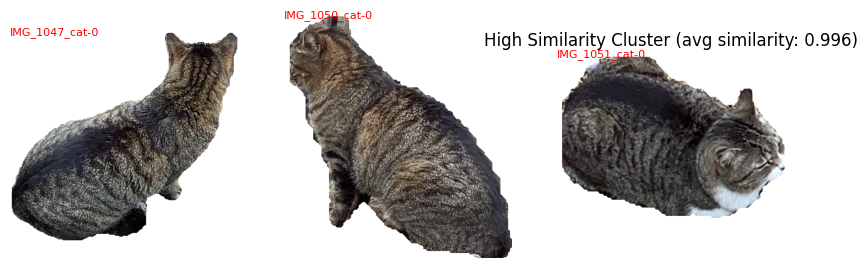

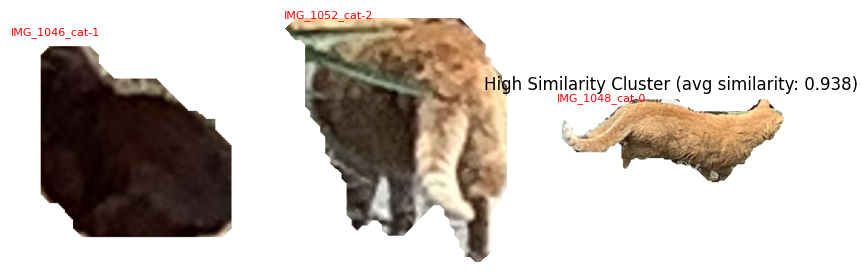

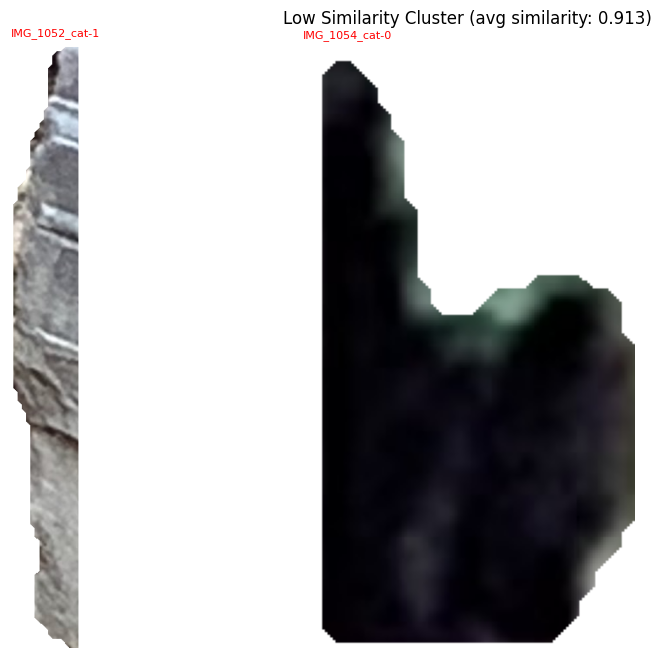

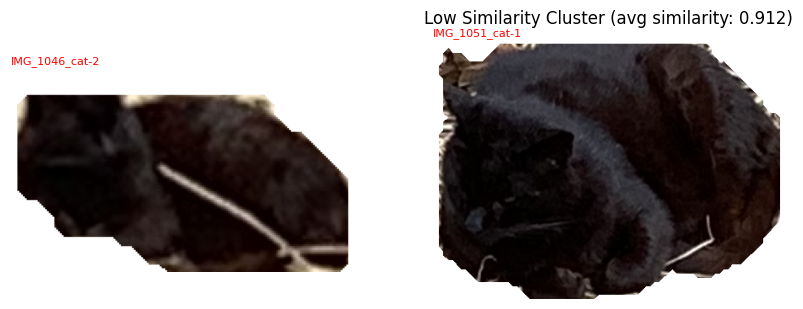

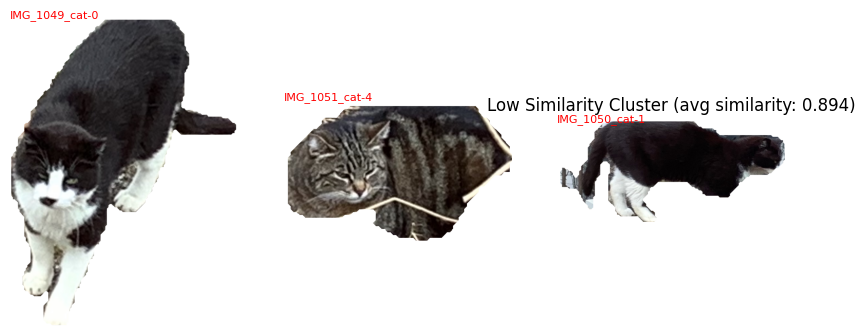

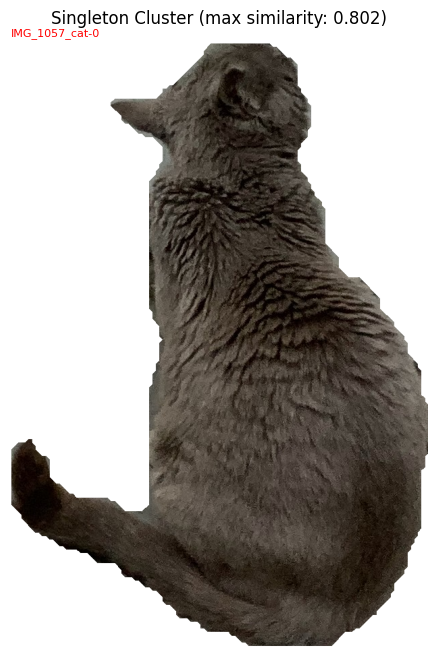

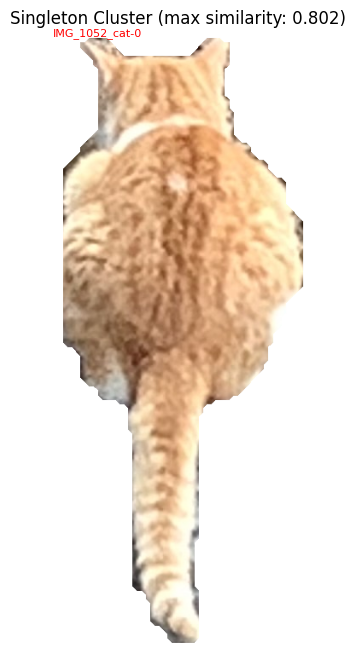

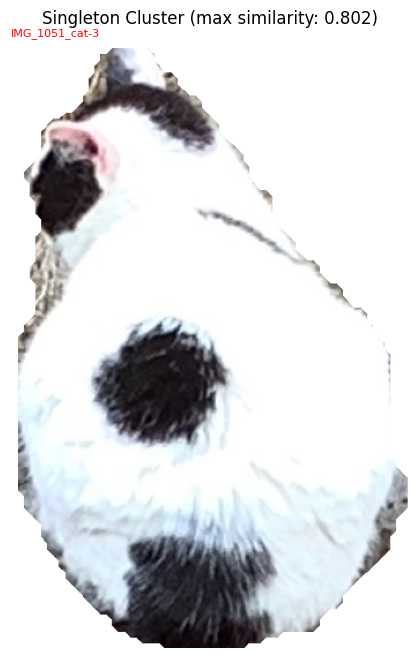

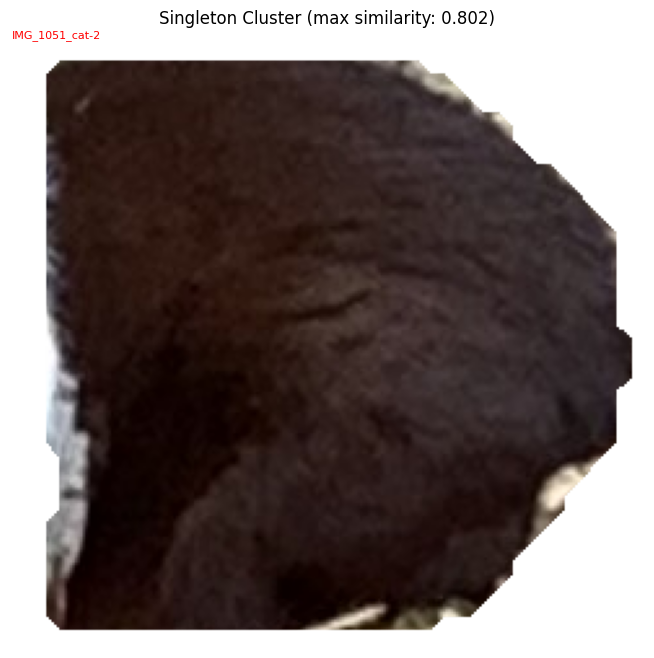

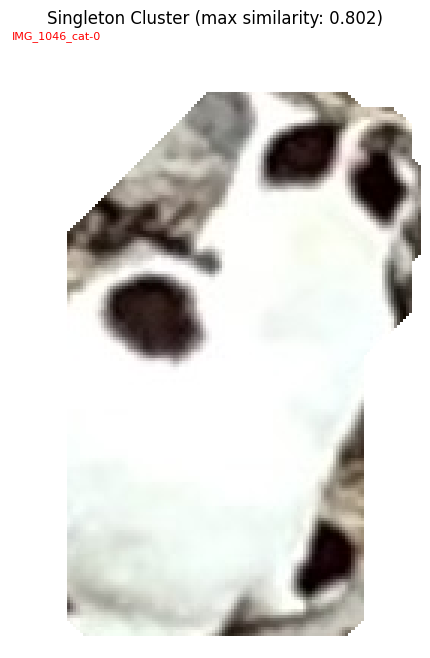

In [47]:
# Load the OpenAI CLIP Model
print('Loading CLIP Model...')
model = SentenceTransformer('clip-ViT-B-32')

# Next we compute the embeddings
image_names = sorted(list(glob.glob(os.path.join(path_to_segmented_images, segmented_image_wildcard_filetype))))
unclustered_image_names = image_names.copy() # used to track which images have been not yet been added to a cluster
print("Number of images: {}".format(len(image_names)))
encoded_images = model.encode([Image.open(os.path.join(path_to_segmented_images, filepath)) for filepath in image_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

# Now we run the clustering algorithm. This function compares images against
# all other images and returns a list with the pairs that have the highest
# cosine similarity score.  Each list has the similarity score followed by the
# indexes (in processed_images) of the images.
processed_images = util.paraphrase_mining_embeddings(encoded_images)

# Now produce a list in which each list element is a list of the form:
# [similarity, processed_images_index1, process_images_index2, image_filename1, image_filename2]
similarities_with_filenames = [list([elt[0], elt[1], elt[2], image_names[elt[1]], image_names[elt[2]]]) for elt in processed_images]

# =================
# DUPLICATES
# =================
print('Finding duplicate images...')
# Filter list for duplicates. Results are triplets (score, image_id1, image_id2) and is scorted in decreasing order.
# The two IDs are indexes into the encoded_images array.
# A duplicate image will have a score of 1.00.  It may be 0.9999 due to lossy image compression (.jpg).
duplicates = [image for image in processed_images if image[0] >= 0.999]

def show_dups(id1, id2):
  fig = plt.figure(figsize=(10,8))
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(imread(image_names[id1]))
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(imread(image_names[id2]))
  plt.axis('off')
  plt.title('Duplicates')
  plt.show()

def get_similarity(data, file1, file2):
  """
  This function retrieves the similarity between two files from a given list.

  Args:
      data: A list of lists, where each inner list contains [similarity, file1, file2].
      file1: The name of the first file.
      file2: The name of the second file.

  Returns:
      The similarity value between file1 and file2, or None if not found.
  """
  for item in data:
    similarity, idx1, idx2, f1, f2 = item
    if (f1 == file1 and f2 == file2) or (f1 == file2 and f2 == file1):
      return similarity
  return None

def get_similarity_of_pair(short_id1, short_id2):
  file1 = path_to_segmented_images + '/' + short_id1 + '.' + segmented_image_wildcard_filetype.split('.')[1]
  file2 = path_to_segmented_images + '/' + short_id2 + '.' + segmented_image_wildcard_filetype.split('.')[1]
  return get_similarity(similarities_with_filenames, file1, file2)

def get_similarity_pairs_for_image(data, target_short_id):
  target_file = path_to_segmented_images + '/' + target_short_id + '.' + segmented_image_wildcard_filetype.split('.')[1]
  print('Getting matches for {}'.format(target_file))
  matches = []
  for item in data:
    similarity, idx1, idx2, f1, f2 = item
    if target_file in (f1, f2):
      matches.append(item)
  return matches

def get_short_id(filename):
  return filename.split('/')[-1].split('.')[0]

def find_max(data):
  """
  This function finds the key amd max value corresponding to the maximum value in a dictionary.

  Args:
      data: A dictionary where keys can be of any type and values are comparable.

  Returns:
      The key and value associated with the maximum value, or None if the dictionary is empty.
  """
  if not data:
    return None
  iterator = iter(data)
  max_key = next(iterator)  # Get any key as a starting point
  max_val = data[max_key]
  if max_val is None:
    max_key = next(iterator)  # Get next key as a starting point
    max_val = data[max_key]
  for key, val in data.items():
    if val is not None and val > max_val:
      max_key = key
      max_val = val
  return max_key, max_val

def show_cluster(cluster, cluster_type):
  """
  This function displays all the images in a cluster.

  Args:
      cluster: The cluster to display.
      cluster_type: The type of cluster to display.

  Returns:
      None.
  """
  fig = plt.figure(figsize=(10,8))
  # skip the first cluster element (the total of the similarity scores, if a high or low threshold cluster,
  # or the max similarity score across singleton clusters, if a singleton)
  for i, image_name in enumerate(cluster[1:]):
    ax = fig.add_subplot(1, len(cluster) - 1, i+1)
    ax.imshow(imread(image_name))
    # Add text with desired position and formatting
    text_to_display = image_name.split('/')[-1].split('.')[0].split(' ')[-1]
    x_pos = 0.1  # Adjust for horizontal placement (0 to 1)
    y_pos = 0.8  # Adjust for vertical placement (0 to 1)
    ax.text(x_pos, y_pos, text_to_display, ha='left', va='center', fontsize=8, color='red')  # Customize font and color
    plt.axis('off')
  avg_similarity = 0
  if len(cluster) > 2:
    avg_similarity = str(round(cluster[0] / (len(cluster) - 2), 3))
  if cluster_type == 'high':
    plt.title('High Similarity Cluster (avg similarity: ' + avg_similarity + ')')
  elif cluster_type == 'low':
    plt.title('Low Similarity Cluster (avg similarity: ' + avg_similarity +')')
  else:
    plt.title('Unknown cluster type: {}'.format(cluster_type))
  plt.show()

def show_singleton_cluster(cluster, cluster_type, singleton_similarities):
  """
  This function displays a singleton cluster.

  Args:
      cluster: The cluster to display.
      cluster_type: 'singleton'
      singleton_similarities: The similarities of the singleton clusters.  A dict of the form {target_id_short: similarity_dict}.
        The similarity_dict is a dict of the form {singleton_id_short: similarity}.  The similarity is None if the singleton_id_short is
        the same as the target_id_short.

  Returns:
      None.
  """
  fig = plt.figure(figsize=(10,8))
  # skip the first cluster element (0 for a singleton)
  for i, image_name in enumerate(cluster[1:]):
    ax = fig.add_subplot(1, len(cluster) - 1, i+1)
    ax.imshow(imread(image_name))
    # Add text with desired position and formatting
    text_to_display = image_name.split('/')[-1].split('.')[0].split(' ')[-1]
    x_pos = 0.1  # Adjust for horizontal placement (0 to 1)
    y_pos = 0.8  # Adjust for vertical placement (0 to 1)
    ax.text(x_pos, y_pos, text_to_display, ha='left', va='center', fontsize=8, color='red')  # Customize font and color
    plt.axis('off')
  _, max_similarity = find_max(singleton_similarities[get_short_id(cluster[1])])
  plt.title('Singleton Cluster (max similarity: ' + str(round(max_similarity, 3)) + ')')
  plt.show()

# Output the top X duplicate images
if len(duplicates) > 0:
  print('Number of duplicate images: {}'.format(len(duplicates)))
  for score, image_id1, image_id2 in duplicates:
    print("\nScore: {:.3f}%".format(score * 100))
    print(image_names[image_id1])
    print(image_names[image_id2])
    show_dups(image_id1, image_id2)
else:
  print('No duplicates found.')

# =================
# NEAR DUPLICATES
# =================
print('Finding near duplicate images...')
# Use a threshold parameter to identify two images as similar. By setting the threshold lower,
# you will get larger clusters which have less similar images in it. Threshold 0 - 1.00
# A threshold of 1.00 means the two images are exactly the same. Since we are finding near
# duplicate images, we can set it at 0.99 or any number 0 < X < 1.00.
threshold = 0.99
near_duplicates = sorted([image for image in processed_images if image[0] < threshold], key=lambda x: x[0], reverse=True)
print('Number of non-duplicate image pairs: {}'.format(len(near_duplicates)))
scores_only = [image[0] for image in processed_images if image[0] < threshold]
print('Max score: {}, min score: {}'.format(max(scores_only), min(scores_only)))

# ===============
# Assemble clusters based on similarity scores
#
# Given a CLUSTER_THRESHOLD value, find all pairs of images whose similarity score is
# >= the CLUSTER_THRESHOLD.  For each image in the pair, find an array within the
# clusters array containing that image's path.  If one is found, add the other image's
# pathname to the cluster; otherwise, start a new cluster with the paths of both
# images.  When a path is added to a cluster, remove that path from the list of all
# image paths.  When all image pairs exceeding the threshold have been processed, proceed as follows
# until all paths have been removed from the list of all image paths.
#
# Continue processing pairs as above, adding new clusters and removing paths from the
# list of all paths, but with these changes:
#.    (1) Do not add any path to the clusters created from pairs exceeding the threshold
#.    (2) Do not add to a cluster any path that appears in one of the clusters whose
#         members exceed the threshold.  This may well lead to singleton clusters, and that's OK.
# ===============

HIGH_CLUSTER_THRESHOLD = 0.92
LOW_CLUSTER_THRESHOLD = 0.85
high_threshold_clusters = []
low_threshold_clusters = []
singleton_clusters = []
IMAGE_FILENAME_PREFIX = 'IMG_'

def normalize_scores(scores, processed_images):
    # Normalize the scores
    max_score = max(scores)
    min_score = min(scores)
    normalized_scores = []
    for image in processed_images:
        score = image[0]
        if score == max_score:
            image[0] = 1
        elif score == min_score:
            image[0] = 0
        else:
            image[0] = (score - min_score) / (max_score - min_score)

def is_high_threshold_cluster(row):
    if row[0] >= HIGH_CLUSTER_THRESHOLD:
        return True
    else:
        return False

def is_low_threshold_cluster(row):
    if row[0] < HIGH_CLUSTER_THRESHOLD and row[0] >= LOW_CLUSTER_THRESHOLD:
        return True
    else:
        return False

def get_cluster_image_names(row):
    return [image_names[row[1]], image_names[row[2]]]

def is_one_cat_in_cluster_set(row, cluster_set):
  # Is either of the cats named in this row already in the cluster set?
  file1, file2 = get_cluster_image_names(row)
  for cluster in cluster_set:
    if file1 in cluster or file2 in cluster:
      return True
  return False

def remove_from_unclustered_images(files):
    for file in files:
        if file in unclustered_image_names:
            unclustered_image_names.remove(file)

def is_file_in_clusters(file, clusters):
    for cluster in clusters:
        if file in cluster:
            return True
    return False

def get_image_and_cat_ids(file):
  # Break the file name into image ID and cat ID components
  # First, remove filename prefix if present
  index = file.find(IMAGE_FILENAME_PREFIX)
  if index != -1:
    file = file[index + len(IMAGE_FILENAME_PREFIX):]
  image_id = file.split('_')[0]
  cat_id = file.split('_')[1].split('.')[0]
  return image_id, cat_id

def is_diff_cat_from_same_image_in_cluster(file, cluster):
  # Check if any element of the cluster is a different cat from the
  # same image as the one denoted by 'file'.  It stands to reason
  # that if a cluster represents different images of the same cat,
  # two cats in the same photo can't be the same cat
  image_id, cat_id = get_image_and_cat_ids(file)
  for cluster_elt in cluster[1:]:
    if image_id == get_image_and_cat_ids(cluster_elt)[0] and cat_id != get_image_and_cat_ids(cluster_elt)[1]:
      return True
  return False

def add_to_singleton_clusters(file):
    for cluster in singleton_clusters:
        if file in cluster:
            return
    singleton_clusters.append([0, file])

def remove_from_singleton_clusters(file):
    for cluster in singleton_clusters:
        if file in cluster:
            singleton_clusters.remove(cluster)
            return

def add_to_cluster(row, clusters):
    file1, file2 = get_cluster_image_names(row)
    # Check if both files are already in clusters within
    # this set of clusters.  If so, no need to do anything.
    # Otherwise, add the files to the appropriate cluster
    file1_in_clusters = is_file_in_clusters(file1, clusters)
    file2_in_clusters = is_file_in_clusters(file2, clusters)
    if file1_in_clusters and file2_in_clusters:
        return
    for cluster in clusters:
        if file1 in cluster:
            if file2 not in cluster:
                # Before adding file2 to cluster, make sure
                # it's not a different cat from the same image
                # as any of the existing cluster elements
                if is_diff_cat_from_same_image_in_cluster(file2, cluster):
                    add_to_singleton_clusters(file2)
                    return
                cluster[0] += row[0]
                cluster.append(file2)
                # There might be a singleton cluster with this element,
                # because it might have been added previously.
                remove_from_singleton_clusters(file2)
            return
        elif file2 in cluster:
            if file1 not in cluster:
                # Before adding file2 to cluster, make sure
                # it's not a different cat from the same image
                # as any of the existing cluster elements
                if is_diff_cat_from_same_image_in_cluster(file1, cluster):
                    add_to_singleton_clusters(file1)
                    return
                cluster[0] += row[0]
                cluster.append(file1)
                # There might be a singleton cluster with this element,
                # because it might have been added previously.
                remove_from_singleton_clusters(file1)
            return
    # Didn't find file1 or file2 in any cluster, so add a new one,
    # as long as they're not both from the same image
    image_id1, cat_id1 = get_image_and_cat_ids(file1)
    image_id2, cat_id2 = get_image_and_cat_ids(file2)
    if image_id1 != image_id2:
    # First element of every cluster is the total of similarity scores
    # for all pairs added to the cluster
      clusters.append([row[0], file1, file2])
      remove_from_singleton_clusters(file1)
      remove_from_singleton_clusters(file2)
    else:
      add_to_singleton_clusters(file1)
      add_to_singleton_clusters(file2)

def add_to_appropriate_cluster(row, debug=False):
    file1, file2 = get_cluster_image_names(row)
    cluster_type = None
    if debug:
      if is_high_threshold_cluster(row):
        cluster_type = 'high threshold'
      elif is_low_threshold_cluster(row):
        cluster_type = 'low threshold'
      print('\nProcessing {} row: {}'.format(cluster_type, list([row[0]]) + get_cluster_image_names(row)))
    # If similarity score is above the high threshold, add row to a high threshold cluster
    if is_high_threshold_cluster(row):
      add_to_cluster(row, high_threshold_clusters)
      remove_from_unclustered_images([file1, file2])
      if debug:
        print('Adding row to high threshold cluster')
        print('Number of high threshold clusters: {}'.format(len(high_threshold_clusters)))
        for c in high_threshold_clusters:
          print(c)
    # If similarity score is below the high threshold, but above the low threshold,
    # add row to a low threshold cluster, but only if neither image has already
    # been assigned to a high threshold cluster
    elif not is_one_cat_in_cluster_set(row, high_threshold_clusters) and is_low_threshold_cluster(row):
      add_to_cluster(row, low_threshold_clusters)
      remove_from_unclustered_images([file1, file2])
      if debug:
        print('Adding row to low threshold cluster')
        print('Number of low threshold clusters: {}'.format(len(low_threshold_clusters)))
        for c in low_threshold_clusters:
          print(c)
    elif not is_one_cat_in_cluster_set(row, high_threshold_clusters) and not is_one_cat_in_cluster_set(row, low_threshold_clusters) :
      add_to_singleton_clusters(file1)
      add_to_singleton_clusters(file2)
      remove_from_unclustered_images([file1, file2])
      if debug:
        print('Adding rows to singleton clusters')
        print('Number of singleton clusters: {}'.format(len(singleton_clusters)))
        for c in singleton_clusters:
          print(c)
    else:
      if debug:
        print('Row was not added to any cluster')

def get_similarity(data, file1, file2):
  """
  This function retrieves the similarity between two files from a given list.

  Args:
      data: A list of lists, where each inner list contains [similarity, file1, file2].
      file1: The name of the first file.
      file2: The name of the second file.

  Returns:
      The similarity value between file1 and file2, or None if not found.
  """
  for item in data:
    similarity, idx1, idx2, f1, f2 = item
    if (f1 == file1 and f2 == file2) or (f1 == file2 and f2 == file1):
      return similarity
  return None

def get_similarity_of_pair(short_id1, short_id2):
  file1 = path_to_segmented_images + '/' + short_id1 + '.' + segmented_image_wildcard_filetype.split('.')[1]
  file2 = path_to_segmented_images + '/' + short_id2 + '.' + segmented_image_wildcard_filetype.split('.')[1]
  return get_similarity(similarities_with_filenames, file1, file2)

def get_similarity_pairs_for_image(data, target_short_id):
  target_file = path_to_segmented_images + '/' + target_short_id + '.' + segmented_image_wildcard_filetype.split('.')[1]
  print('Getting matches for {}'.format(target_file))
  matches = []
  for item in data:
    similarity, idx1, idx2, f1, f2 = item
    if target_file in (f1, f2):
      matches.append(item)
  return matches

print('Normalizing scores...')
# Normalize the scores
normalize_scores(scores_only, near_duplicates)
print('Clustering images based on normalized similarity scores...')
# Process every pair regardless of similarity score
for row in near_duplicates:
    # Continue processing until every image has been assigned to a cluster
    if len(unclustered_image_names) > 0:
        add_to_appropriate_cluster(row)
    else:
        break

print('Number of high threshold clusters: {}'.format(len(high_threshold_clusters)))
print('Number of low threshold clusters: {}'.format(len(low_threshold_clusters)))
print('Number of singleton clusters: {}'.format(len(singleton_clusters)))

keys = [single[1] for single in singleton_clusters]
similarities_for_singletons = {get_short_id(key): {get_short_id(other_key): get_similarity(similarities_with_filenames, keys[0], other_key) for other_key in keys} for key in keys}

for cluster in sorted(high_threshold_clusters, key = lambda cluster: cluster[0] / (len(cluster) - 2), reverse=True):
  show_cluster(cluster, 'high')
for cluster in sorted(low_threshold_clusters, key = lambda cluster: cluster[0] / (len(cluster) - 2), reverse=True):
  show_cluster(cluster, 'low')
for cluster in sorted(singleton_clusters, reverse=True):
  show_singleton_cluster(cluster, 'singleton', similarities_for_singletons)